In [1]:

import matplotlib as mpl
import argparse
import os
import sys
sys.path.insert(1, os.path.realpath(os.path.pardir))
from utils.storage import DLStorageIterator, STAGE
from utils.preprocessing import BasicPreprocessor, Preprocessed
import numpy as np
import pandas as pd
from time import perf_counter
import re
import logging
import matplotlib.pyplot as plt
from utils import balance
import scipy
import torch
from deepmeg.data.datasets import EpochsDataset
from deepmeg.utils.params import LFCNNParameters
from deepmeg.experimental.params import SPIRITParameters
from deepmeg.preprocessing.transforms import zscore
import scipy as sp

def set_ticks_invisible(ax, side='x'):
    if side == 'x':
        axis = ax.xaxis
    elif side == 'y':
        axis = ax.yaxis
    else:
        raise ValueError(f'Incorret side "{side}", use x or y only')
    for tick in axis.get_major_ticks():
        tick.tick1line.set_visible(False)
        tick.tick2line.set_visible(False)
        tick.label1.set_visible(False)
        tick.label2.set_visible(False)


def gaussian_random_walk(n: int, stepsize: float = 1.0) -> np.ndarray:
    # Generate random steps using a Gaussian distribution
    steps = np.random.normal(loc=0, scale=stepsize, size=(n, 2))

    # Compute the coordinates of the random walk by cumulatively summing the steps
    walk = np.cumsum(steps, axis=0)

    return walk.T[0]

def sample_spherical(x, y, z):
    vec = np.stack([x, y, z], axis=0)
    vec /= np.linalg.norm(vec, axis=0)
    return vec


def plot_latent_space(
    latent1: np.ndarray,
    latent2: np.ndarray,
    latent3: np.ndarray,
    target: np.ndarray
):

    assert len({len(i) for i in (latent1, latent2, latent3)}) == 1, f'given latent variables hase different samplings1: {len(latent1)}, {len(latent2)}, {len(latent3)}'
    assert len(target) == len(latent1), f'Target variable course has different sampling: {len(target)} ~ {len(latent1)}'

    xx, yy, zz = sample_spherical(latent1, latent2, latent3)

    fig = plt.figure()
    sfig1, sfig2 = fig.subfigures(1, 2, wspace=0.07)

    gs1 = sfig1.add_gridspec(3, 5)
    gs2 = sfig2.add_gridspec(5, 5)

    ax1 = sfig1.add_subplot(gs1[0, :])
    ax2 = sfig1.add_subplot(gs1[1, :])
    ax3 = sfig1.add_subplot(gs1[2, :])

    ax1.plot(target, latent1)
    ax1.set_ylabel('latent 1')
    set_ticks_invisible(ax1)
    ax2.plot(target, latent2)
    ax2.set_ylabel('latent 2')
    set_ticks_invisible(ax2)
    ax3.plot(target, latent3)
    ax3.set_ylabel('latent 3')
    ax3.set_xlabel('time')

    ax4 = sfig2.add_subplot(gs2[:, :], projection='3d')

    m = ax4.scatter(
        xx, yy, zz,
        c=target,
        cmap='cool'
    )
    ax4.set_xlabel('latent 1')
    ax4.set_ylabel('latent 2')
    ax4.set_zlabel('latent 3')

    ax5 = sfig2.add_subplot(gs2[0, 0:2])

    c = ax5.imshow(
        np.corrcoef(np.stack([
            latent1,
            latent2,
            latent3
        ])),
        cmap='seismic',
        vmin=-1, vmax=1
    )
    set_ticks_invisible(ax5, side='x')
    set_ticks_invisible(ax5, side='y')

    plt.colorbar(m, ax=ax4, location='bottom', aspect=50, fraction=0.02)
    plt.colorbar(c, ax=ax5, location='right')

    return fig


/data/pt_02648/NeuralGeometry/venv/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


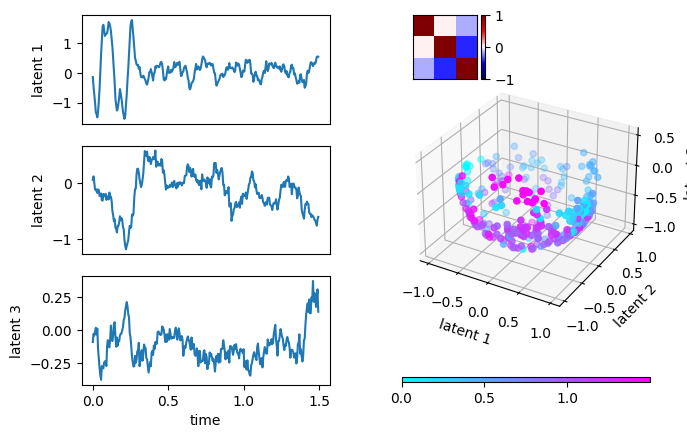

In [5]:
%matplotlib qt

params_path = '../../spatual/RESULTS/sbj02/training_acc_lfcnnw/params.pkl'
params = SPIRITParameters.load(params_path)
time_courses_filtered = params.temporal.time_courses_filtered[:, np.argsort(params.order)[::-1], :]

plot_latent_space(
    time_courses_filtered.mean(0)[0],
    time_courses_filtered.mean(0)[1],
    time_courses_filtered.mean(0)[2],
    params.temporal.times
)

In [ ]:
%matplotlib inline
# params_path = '../../spatual/RESULTS/sbj02/action_lfcnnw/params.pkl'
params_path = '../../spatual/RESULTS/sbj21/training_acc_lfcnnw/params.pkl'
# params_path = '../../spatual/RESULTS/sbj21/training_acc_lfcnnw/params.pkl'
params = SPIRITParameters.load(params_path)

interp_cubic = lambda y, n: sp.interpolate.interp1d(params.temporal.times, y, 'cubic')(np.linspace(params.temporal.times[0], params.temporal.times[-1], n))

time_courses_filtered = params.temporal.time_courses_filtered[:, np.argsort(params.order)[::-1], :]
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
ax1.plot(params.temporal.times, time_courses_filtered.mean(0)[0])
ax2.plot(params.temporal.times, time_courses_filtered.mean(0)[1])
ax3.plot(params.temporal.times, time_courses_filtered.mean(0)[2])

In [250]:
n = 300
t = np.linspace(params.temporal.times[0], params.temporal.times[-1], n)
%matplotlib qt

time_courses_filtered = params.temporal.time_courses_filtered[:, np.argsort(params.order)[::-1], :]


xx, yy, zz = sample_spherical(
    interp_cubic(time_courses_filtered.mean(0)[0], n),
    interp_cubic(time_courses_filtered.mean(0)[1], n),
    interp_cubic(time_courses_filtered.mean(0)[2], n)
)

# xx, yy, zz = \
#     interp_cubic(time_courses_filtered.mean(0)[0], n),\
#     interp_cubic(time_courses_filtered.mean(0)[1], n),\
#     interp_cubic(time_courses_filtered.mean(0)[2], n)

plt.scatter(xx, yy, c=t, cmap='cool',)

ax = plt.figure().add_subplot(projection='3d')
m = ax.scatter(
    xx, yy, zz,
    c=t,
    cmap='cool',
    s=5
)
ax.set_xlabel('latent 1')
ax.set_ylabel('latent 2')
ax.set_zlabel('latent 3')
plt.colorbar(m, ax=ax, location='bottom', aspect=50, fraction=0.02)

In [234]:
plt.plot(t, interp_cubic(time_courses_filtered.mean(0)[0], n), t, xx)
plt.legend(['without', 'with'])

In [237]:
%matplotlib qt

time_courses_filtered = params.temporal.time_courses_filtered[:, np.argsort(params.order)[::-1], :]

time_courses_random = np.random.random(time_courses_filtered.mean(0).shape) - .5





# xx, yy, zz = sample_spherical(time_courses_random[0], time_courses_random[1], time_courses_random[2])

xx, yy, zz = sample_spherical(time_courses_filtered.mean(0)[0], time_courses_filtered.mean(0)[1], time_courses_filtered.mean(0)[2])

# xx, yy, zz = sample_spherical(time_courses_filtered[0][0], time_courses_filtered[0][1], time_courses_filtered[0][2])


# xx, yy, zz = sample_spherical(np.random.random(1000) - .5, np.random.random(1000) - .5, np.random.random(1000) - .5)
# n = 1000

plt.scatter(xx, yy, c=params.temporal.times, cmap='cool',)

ax = plt.figure().add_subplot(projection='3d')
m = ax.scatter(
    xx, yy, zz,
    c=params.temporal.times,
    # c=np.linspace(0, 1, n),
    cmap='cool',
    s=5
)
ax.set_xlabel('latent 1')
ax.set_ylabel('latent 2')
ax.set_zlabel('latent 3')
plt.colorbar(m, ax=ax, location='bottom', aspect=50, fraction=0.02)

In [413]:
import numpy as np
import matplotlib.pyplot as plt

# Generate time vector
t = np.linspace(0, 10, 100)

# Create three linearly independent signals
s1 = t
s2 = np.sin(t)
s3 = np.cos(t)

# Combine signals to create quadratically dependent signal
s4 = s1**2 + s2**2 + s3**2

# Plot signals
plt.figure(figsize=(8, 6))
plt.plot(t, s1, label='Signal 1')
plt.plot(t, s2, label='Signal 2')
plt.plot(t, s3, label='Signal 3')
plt.plot(t, s4, label='Signal 4')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.show()

In [449]:



n = 1000
# t = np.linspace(0, 2, n)

x, y, z = gaussian_random_walk(n), gaussian_random_walk(n), gaussian_random_walk(n)

# yy = (xx + yy) / 2
# zz = (xx + zz) / 2
xx = np.sin(5*t) * np.exp(-(t - 5)**2/10)
yy = np.sin(10*t) * np.exp(-(t - 5)**2/2)
zz = np.sin(10*t) * np.exp(-(t - 1)**2/2)

plot_latent_space(
    sp.stats.zscore(xx),
    sp.stats.zscore(yy),
    sp.stats.zscore(zz),
    t
)

AttributeError: 'list' object has no attribute 'get_array'

In [2]:
project_name = 'project_name'
subjects_dir = '../../spatual/Preprocessed/'
classification_name_formatted = 'testname'

iterator = DLStorageIterator(subjects_dir, name=classification_name_formatted)

In [13]:
next(iterator)

'sbj02'

In [15]:
os.listdir(iterator.history_path)

['training_acc_lfcnnw.csv',
 '.~lock.prptsc_action_8_branches_balanced.csv#',
 'group_pr_vs_pt_lfcnn.csv',
 'group_training_acc_lfcnnw.csv',
 'group_generalization_training_acc_lfcnn_con.csv',
 's_vs_c_pre.csv',
 'group_even_sp_training_acc_lfcnnw.csv',
 'action_fourier.csv',
 'group_even_pr_vs_pt_lfcnn.csv',
 '.~lock.s_vs_c_post.csv#',
 'group_even_pr_vs_pt_lfcnnw.csv',
 '.~lock.congr_incongr.csv#',
 'group_generalization_even_training_acc_lfcnn_con.csv',
 'action_fourier_old.csv',
 'group_odd_training_acc_lfcnnw.csv',
 'group_odd_con_training_acc_lfcnnw.csv',
 'v_vs_c_0.csv',
 'pr_vs_pt_lfcnnw.csv',
 'group_generalization_even_training_acc_lfcnn_sp.csv',
 '.~lock.action_fourier.csv#',
 'group_generalization_odd_training_acc_lfcnnw_sp.csv',
 'group_generalization_training_acc_lfcnn_sp.csv',
 'group_generalization_training_acc_lfcnnw_con.csv',
 'prptsc_clusters_16_branches_balanced.csv',
 'group_odd_sp_training_acc_lfcnnw.csv',
 'group_action_lfcnn.csv',
 'action_lfcnnw.csv',
 'group_o

In [26]:
df = pd.read_csv(os.path.join(iterator.history_path, 'training_acc_lfcnnw.csv'), index_col=0)
df['new'] = np.nan
df['new']['sbj02'] = 0.54

In [ ]:
from cebra import CEBRA

In [27]:
df['new']

sbj02    0.54
sbj03     NaN
sbj04     NaN
sbj05     NaN
sbj07     NaN
sbj08     NaN
sbj09     NaN
sbj10     NaN
sbj11     NaN
sbj12     NaN
sbj13     NaN
sbj14     NaN
sbj15     NaN
sbj16     NaN
sbj17     NaN
sbj18     NaN
sbj19     NaN
sbj20     NaN
sbj21     NaN
sbj22     NaN
sbj23     NaN
sbj24     NaN
sbj25     NaN
sbj26     NaN
sbj27     NaN
sbj28     NaN
sbj30     NaN
Name: new, dtype: float64

In [7]:
a = np.arange(100)
np.random.shuffle(a)

In [10]:
a = [1, 2, 3, 4, 5]
b = [0] + a
a[0] += 1
a, b

([2, 2, 3, 4, 5], [0, 1, 2, 3, 4, 5])

In [4]:
iterator.subject_dirs

['sbj02',
 'sbj03',
 'sbj04',
 'sbj05',
 'sbj07',
 'sbj08',
 'sbj09',
 'sbj10',
 'sbj11',
 'sbj12',
 'sbj13',
 'sbj14',
 'sbj15',
 'sbj16',
 'sbj17',
 'sbj18',
 'sbj19',
 'sbj20',
 'sbj21',
 'sbj22',
 'sbj23',
 'sbj24',
 'sbj25',
 'sbj26',
 'sbj27',
 'sbj28',
 'sbj30',
 'sbj32',
 'sbj33',
 'sbj34',
 'sbj35',
 'sbj36']